In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# data

In [2]:

path_return = r'C:\Users\User\Desktop\quant\Sector Allocation Framework under Reinforcement Learning Rotation\returns_data_temp.csv'
path_cluster = r'C:\Users\User\Desktop\quant\Sector Allocation Framework under Reinforcement Learning Rotation\cluster_data_temp.csv'

cluster_data_temp = pd.read_csv(path_cluster)
returns_data_temp = pd.read_csv(path_return)

path = r'h:\我的雲端硬碟\DEV_INTERN_ALPHA_DATA-20240709T015049Z-001\DEV_INTERN_ALPHA_DATA\pmart.parquet'
df = pd.read_parquet(path)
pmart_column_lst = df.columns.tolist()[2:]
pmart_data_dict = {}

pmart_column_lst = df.columns.tolist()[2:]
pmart_column_lst = [col for col in pmart_column_lst if col not in ['季別', '合併(Y/N)', '單季(Q)/單半年(H)', '月份', '幣別', '近一週報酬率(%)', '近一月報酬率(%)', '近一季報酬率(%)', '近一年報酬率(%)']]

for column in pmart_column_lst:
    temp_df = df[['datetime', 'symbol' , column]]
    pmart_data_dict[column] = temp_df.pivot_table(
    index='datetime',  # 行索引
    columns='symbol',  # 列名稱
    values=column,  # 數值
)
    
industry_path = r"C:\Users\User\Desktop\quant\Sector Allocation Framework under Reinforcement Learning Rotation\security_properties.parquet"
property_data = pd.read_parquet(industry_path)

property_data = property_data.reset_index()
property_data = property_data[property_data['industry'].notna()]
symbol_to_industry = property_data[['symbol', 'industry']].set_index('symbol')['industry']

# 創建一個新 dictionary，用於儲存轉換後的 DataFrame
industry_data_dict = {}

for key, df in pmart_data_dict.items():
    # 重設 DataFrame 的列索引，將 symbol 映射為 industry
    df = df.rename(columns=symbol_to_industry).copy()
    
    # 基於 industry 聚合，計算平均值
    df = df.groupby(axis=1, level=0).mean()
    
    # 儲存到新的 dictionary
    industry_data_dict[key] = df

# 結果：industry_data_dict 包含的 DataFrame 是基於產業的全平均

feature_dict = pd.DataFrame()

# 合併多個df以符合RL所需格式
def reorganize_industry_data(industry_data_dict):
    """
    重組產業指標數據，將產業作為第一層，指標作為第二層
    
    Parameters:
    industry_data_dict: Dict[str, pd.DataFrame] - 指標資料字典，key為指標名稱
    
    Returns:
    pd.DataFrame - 重組後的DataFrame，MultiIndex為(產業, 指標)
    """
    # 取得所有日期作為索引
    all_dates = set()
    for df in industry_data_dict.values():
        all_dates.update(df.index)
    all_dates = sorted(list(all_dates))
    
    # 取得所有產業名稱
    industries = industry_data_dict[list(industry_data_dict.keys())[0]].columns
    
    # 創建新的DataFrame
    result_dict = {}
    
    # 重組數據
    for industry in industries:
        for indicator, df in industry_data_dict.items():
            if industry in df.columns:
                # 使用元組作為鍵，第一層是產業，第二層是指標
                result_dict[(industry, indicator)] = df[industry]
    
    # 創建最終的DataFrame
    result_df = pd.DataFrame(result_dict, index=all_dates)
    
    # 確保MultiIndex格式正確
    result_df.columns = pd.MultiIndex.from_tuples(result_df.columns)
    
    return result_df

# Fundamental feature

fundamental_lst = [
    "每股盈餘",
    "ROA(C) 稅前息前折舊前",  # 資產報酬率
    "ROE(A)-稅後",  # 股東權益報酬率
    "營業毛利率",
    "營業利益率",
    "稅後淨利率",
    "流動比率",
    "速動比率",
    "負債比率",
    "長期資金適合率(A)",
    "CFO/負債",
    "CFO/合併總損益",
    "現金流量比率",
    "營收成長率",
    "營業毛利成長率",
    "營業利益成長率"
]

fundamental_dict = {key: industry_data_dict[key] for key in fundamental_lst if key in industry_data_dict}

fundamental_feature = reorganize_industry_data(fundamental_dict)
fundamental_feature

C:\Users\User\AppData\Local\Temp\ipykernel_6960\2686901085.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_6960\2686901085.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_6960\2686901085.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_6960\2686901085.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_6960\2686901085.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.

光電業                                                           \
                每股盈餘 ROA(C) 稅前息前折舊前 ROE(A)-稅後      營業毛利率      營業利益率     稅後淨利率   
2013-05-15  0.227706       1.739083 -0.308349   9.020000  -9.252569 -7.825413   
2013-05-16  0.227706       1.739083 -0.308349   9.020000  -9.252569 -7.825413   
2013-05-17  0.227706       1.739083 -0.308349   9.020000  -9.252569 -7.825413   
2013-05-20  0.227706       1.739083 -0.308349   9.020000  -9.252569 -7.825413   
2013-05-21  0.227706       1.739083 -0.308349   9.020000  -9.252569 -7.825413   
...              ...            ...       ...        ...        ...       ...   
2024-06-13  3.347071       6.278384  2.638788  17.876162 -11.568788  1.539798   
2024-06-14  3.347071       6.278384  2.638788  17.876162 -11.568788  1.539798   
2024-06-17  3.347071       6.278384  2.638788  17.876162 -11.568788  1.539798   
2024-06-18  3.347071       6.278384  2.638788  17.876162 -11.568788  1.539798   
2024-06-19  3.347071       6.278384  2.638788  17.876162 -11.568788  1.539798   

                                                            ...    食品工業  \
                  流動比率        速動比率       負債比率   長期資金適合率(A)  ...    流動比率   
2013-05-15  193.289083  138.493853  42.542385   277.254312  ...  273.83   
2013-05-16  193.289083  138.493853  42.542385   277.254312  ...  273.83   
2013-05-17  193.289083  138.493853  42.542385   277.254312  ...  273.83   
2013-05-20  193.289083  138.493853  42.542385   277.254312  ...  273.83   
2013-05-21  193.289083  138.493853  42.542385   277.254312  ...  273.83   
...                ...         ...        ...          ...  ...     ...   
2024-06-13  354.024747  296.764545  35.277677  2662.809091  ...  261.11   
2024-06-14  354.024747  296.764545  35.277677  2662.809091  ...  261.11   
2024-06-17  354.024747  296.764545  35.277677  2662.809091  ...  261.11   
2024-06-18  354.024747  296.764545  35.277677  2662.809091  ...  261.11   
2024-06-19  354.024747  296.764545  35.277677  2662.809091  ...  261.11   

                                                                              \
                  速動比率       負債比率 長期資金適合率(A)    CFO/負債  CFO/合併總損益     現金流量比率   
2013-05-15  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-16  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-17  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-20  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-21  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
...                ...        ...        ...       ...        ...        ...   
2024-06-13  182.222500  36.582500  255.92250  0.320000   1.542500  12.059167   
2024-06-14  182.222500  36.582500  255.92250  0.320000   1.542500  12.059167   
2024-06-17  182.222500  36.582500  255.92250  0.320000   1.542500  12.059167   
2024-06-18  182.222500  36.582500  255.92250  0.320000   1.542500  12.059167   
2024-06-19  182.222500  36.582500  255.92250  0.320000   1.542500  12.059167   

                                              
                營收成長率   營業毛利成長率      營業利益成長率  
2013-05-15   5.011667 -27.79625  1613.193333  
2013-05-16   5.011667 -27.79625  1613.193333  
2013-05-17   5.011667 -27.79625  1613.193333  
2013-05-20   5.011667 -27.79625  1613.193333  
2013-05-21   5.011667 -27.79625  1613.193333  
...               ...       ...          ...  
2024-06-13  17.015000  29.99625    34.852083  
2024-06-14  17.015000  29.99625    34.852083  
2024-06-17  17.015000  29.99625    34.852083  
2024-06-18  17.015000  29.99625    34.852083  
2024-06-19  17.015000  29.99625    34.852083  

[2716 rows x 398 columns]

In [3]:
features_dict_temp = {}
features_dict_temp['fundamantal'] = fundamental_feature.iloc[:150]
features_dict_temp['fundamantal'].head()

光電業                                                     \
                每股盈餘 ROA(C) 稅前息前折舊前 ROE(A)-稅後 營業毛利率     營業利益率     稅後淨利率   
2013-05-15  0.227706       1.739083 -0.308349  9.02 -9.252569 -7.825413   
2013-05-16  0.227706       1.739083 -0.308349  9.02 -9.252569 -7.825413   
2013-05-17  0.227706       1.739083 -0.308349  9.02 -9.252569 -7.825413   
2013-05-20  0.227706       1.739083 -0.308349  9.02 -9.252569 -7.825413   
2013-05-21  0.227706       1.739083 -0.308349  9.02 -9.252569 -7.825413   

                                                           ...    食品工業  \
                  流動比率        速動比率       負債比率  長期資金適合率(A)  ...    流動比率   
2013-05-15  193.289083  138.493853  42.542385  277.254312  ...  273.83   
2013-05-16  193.289083  138.493853  42.542385  277.254312  ...  273.83   
2013-05-17  193.289083  138.493853  42.542385  277.254312  ...  273.83   
2013-05-20  193.289083  138.493853  42.542385  277.254312  ...  273.83   
2013-05-21  193.289083  138.493853  42.542385  277.254312  ...  273.83   

                                                                              \
                  速動比率       負債比率 長期資金適合率(A)    CFO/負債  CFO/合併總損益     現金流量比率   
2013-05-15  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-16  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-17  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-20  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   
2013-05-21  191.565417  39.332917  307.09125  0.181579  31.411053  13.037083   

                                             
               營收成長率   營業毛利成長率      營業利益成長率  
2013-05-15  5.011667 -27.79625  1613.193333  
2013-05-16  5.011667 -27.79625  1613.193333  
2013-05-17  5.011667 -27.79625  1613.193333  
2013-05-20  5.011667 -27.79625  1613.193333  
2013-05-21  5.011667 -27.79625  1613.193333  

[5 rows x 398 columns]

In [4]:
cluster_data_temp['datetime'] = pd.to_datetime(cluster_data_temp['datetime'])  # 將欄位轉為 datetime 格式
cluster_data_temp.set_index('datetime', inplace=True)          # 將其設為索引
cluster_data_temp = cluster_data_temp.iloc[:150]
cluster_data_temp.head() 

,光電業,其他,化學工業,半導體,居家生活,建材營造,數位雲端,文化創意業,材料,汽車工業,...,資訊服務業,通信網路業,金融業,鋼鐵工業,電子商務,電子通路業,電子零組件,電機機械,電腦及週邊,食品工業
datetime,,,,,,,,,,,,,,,,,,,,,
2013-05-15,4,2,2,0,2,2,5,0,2,0,...,1,0,0,2,3,2,0,2,2,0
2013-05-16,4,2,2,0,2,2,5,0,2,0,...,1,0,0,2,3,2,0,2,2,0
2013-05-17,4,2,2,0,2,2,5,0,2,0,...,1,0,0,2,3,2,0,2,2,0
2013-05-20,4,2,2,0,2,2,5,0,2,0,...,1,0,0,2,3,2,0,2,2,0
2013-05-21,4,2,2,0,2,2,5,0,2,0,...,1,0,0,2,3,2,0,2,2,0


In [5]:
returns_data_temp['datetime'] = pd.to_datetime(returns_data_temp['datetime'])  # 將欄位轉為 datetime 格式
returns_data_temp.set_index('datetime', inplace=True)          # 將其設為索引
returns_data_temp = returns_data_temp.iloc[:150]
returns_data_temp.head()

,光電業,其他,化學工業,半導體,居家生活,建材營造,數位雲端,文化創意業,材料,汽車工業,...,資訊服務業,通信網路業,金融業,鋼鐵工業,電子商務,電子通路業,電子零組件,電機機械,電腦及週邊,食品工業
datetime,,,,,,,,,,,,,,,,,,,,,
2013-05-15,1.302608,0.642286,0.555994,0.421326,1.430424,1.199804,0.832743,0.068016,0.975402,1.106733,...,0.286967,0.635315,1.274580,0.236545,-0.3968,-0.102849,0.512790,0.240838,0.603218,0.727992
2013-05-16,1.185714,-0.036057,0.197428,0.836739,0.817339,0.699168,2.735586,0.446837,0.767758,1.139428,...,-0.042337,0.187807,2.271045,0.364575,1.1952,0.554331,0.188547,0.507773,0.340185,0.243037
2013-05-17,1.512616,0.441230,0.179203,0.155004,0.421407,0.382724,3.806300,0.589184,0.117923,0.165011,...,-0.043563,0.443001,-0.204555,0.104760,6.6929,0.521608,0.628443,0.076025,0.577626,0.914350
2013-05-20,1.834277,0.620290,0.049575,0.013956,0.202222,0.684601,1.009814,-0.270089,0.459767,0.013900,...,0.825748,0.479855,0.919307,0.421353,-4.7970,0.774603,0.669102,0.433365,0.482416,0.439271
2013-05-21,1.433981,0.840786,0.208633,1.255811,0.770324,1.245729,0.011843,-0.419305,0.657993,0.488272,...,1.186656,0.174277,-0.196455,1.180495,-0.7752,1.235131,0.763970,0.588637,0.942956,0.161783


# RL

In [7]:
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from typing import Dict, List, Tuple
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import os
import psutil

In [8]:
# 檢查資料
print("特徵日期範圍:", features_dict_temp['fundamantal'].index.min(), "-", features_dict_temp['fundamantal'].index.max())
print("分群日期範圍:", cluster_data_temp.index.min(), "-", cluster_data_temp.index.max())
print("報酬日期範圍:", returns_data_temp.index.min(), "-", returns_data_temp.index.max())


特徵日期範圍: 2013-05-15 00:00:00 - 2014-12-19 00:00:00
分群日期範圍: 2013-05-15 00:00:00 - 2014-12-19 00:00:00
報酬日期範圍: 2013-05-15 00:00:00 - 2014-12-19 00:00:00


# RL 單模型測試

In [14]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from typing import Dict, Tuple
import torch

class SimpleIndustryEnv(gym.Env):
    def __init__(self, features_dict: Dict[str, pd.DataFrame], returns_data: pd.DataFrame):
        super().__init__()
        
        self.features_dict = self._process_features_dict(features_dict)
        self.returns_data = returns_data
        self.industry_names = list(returns_data.columns)  # Store column names as list
        self.n_industries = len(self.industry_names)
        self.total_features = sum(df.shape[1] for df in self.features_dict.values())
        
        self.action_space = spaces.Discrete(self.n_industries)
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.total_features,),
            dtype=np.float32
        )
        
        self.current_step = 0
        
    def _process_features_dict(self, features_dict):
        processed = {}
        for key, df in features_dict.items():
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = ['_'.join(map(str, col)).strip() for col in df.columns]
            processed[key] = df.fillna(0)
        return processed
    
    def _get_state(self) -> np.ndarray:
        current_date = self.returns_data.index[self.current_step]
        state = []
        
        for df in self.features_dict.values():
            values = df.loc[current_date].values
            values = np.nan_to_num(values, nan=0.0)
            state.extend(values)
            
        return np.array(state, dtype=np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, dict]:
        next_returns = self.returns_data.iloc[self.current_step + 1]
        reward = float(next_returns.iloc[action])
        reward = np.nan_to_num(reward, nan=0.0)
        
        self.current_step += 1
        done = self.current_step >= len(self.returns_data) - 2
        
        return self._get_state(), reward, done, False, {}
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return self._get_state(), {}

def train_and_predict(features_dict: Dict[str, pd.DataFrame], returns_data: pd.DataFrame,
                     train_size: int = 120, total_timesteps: int = 10000):
    returns_data = returns_data.fillna(0)
    
    train_features = {k: v.iloc[:train_size] for k, v in features_dict.items()}
    train_returns = returns_data.iloc[:train_size]
    test_returns = returns_data.iloc[train_size:]
    
    env = SimpleIndustryEnv(train_features, train_returns)
    
    model = PPO(
        'MlpPolicy', 
        env,
        verbose=0,
        device='cpu',
        policy_kwargs={'net_arch': [64, 64]}
    )
    
    model.learn(total_timesteps=total_timesteps)
    
    obs = env.reset()[0]
    predicted_industry_idx, _ = model.predict(obs, deterministic=True)
    
    # Calculate cumulative sum of returns for each industry
    test_returns_sum = test_returns.sum()
    
    # Convert integer index to industry name
    predicted_industry = env.industry_names[predicted_industry_idx]
    actual_best_industry = test_returns_sum.idxmax()
    
    predicted_return = float(test_returns_sum[predicted_industry])
    best_return = float(test_returns_sum.max())
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'train_start': [train_returns.index[0]],
        'train_end': [train_returns.index[-1]],
        'predict_start': [test_returns.index[0]],
        'predict_end': [test_returns.index[-1]],
        'predicted_industry': [predicted_industry],
        'actual_best_industry': [actual_best_industry],
        'predicted_return': [predicted_return],
        'best_return': [best_return],
        'prediction_accuracy': [predicted_industry == actual_best_industry],
        'return_difference': [predicted_return - best_return]
    })
    
    return result_df

# Helper function to check data quality
def check_data_quality(features_dict, returns_data):
    print("Returns Data Shape:", returns_data.shape)
    print("\nReturns Data NaN Count:\n", returns_data.isna().sum())
    
    print("\nFeatures Data:")
    for key, df in features_dict.items():
        print(f"\n{key} Shape:", df.shape)
        print(f"{key} NaN Count:\n", df.isna().sum())

In [33]:
def filter_ecommerce(features_dict, returns_data):
    # 過濾 returns_data
    non_ecommerce_returns = returns_data.drop(columns=[col for col in returns_data.columns 
                                                     if '電子商務' in col])
    
    # 過濾 features_dict
    non_ecommerce_features = {}
    for key, df in features_dict.items():
        # 移除包含電子商務的欄位
        filtered_cols = [col for col in df.columns if '電子商務' not in col]
        non_ecommerce_features[key] = df[filtered_cols]
    
    return non_ecommerce_features, non_ecommerce_returns

In [34]:
feature_dict, returns_data = filter_ecommerce(features_dict_temp, returns_data_temp)

In [35]:
# 檢查數據質量
check_data_quality(feature_dict, returns_data)

Returns Data Shape: (150, 24)

Returns Data NaN Count:
 光電業      0
其他       0
化學工業     0
半導體      0
居家生活     0
建材營造     0
數位雲端     0
文化創意業    0
材料       0
汽車工業     0
油電燃氣業    0
生技醫療     0
綠能環保     0
航運業      0
觀光餐旅     0
資訊服務業    0
通信網路業    0
金融業      0
鋼鐵工業     0
電子通路業    0
電子零組件    0
電機機械     0
電腦及週邊    0
食品工業     0
dtype: int64

Features Data:

fundamantal Shape: (150, 384)
fundamantal NaN Count:
 光電業   每股盈餘              0
      ROA(C) 稅前息前折舊前    0
      ROE(A)-稅後         0
      營業毛利率             0
      營業利益率             0
                       ..
食品工業  CFO/合併總損益         0
      現金流量比率            0
      營收成長率             0
      營業毛利成長率           0
      營業利益成長率           0
Length: 384, dtype: int64


In [38]:
result_df = train_and_predict(
    feature_dict,
    returns_data,
    train_size=120,
    total_timesteps=10000
)

result_df

,train_start,train_end,predict_start,predict_end,predicted_industry,actual_best_industry,predicted_return,best_return,prediction_accuracy,return_difference
0,2013-05-15,2013-11-04,2013-11-05,2013-12-16,數位雲端,汽車工業,2.127212,10.210612,False,-8.083399


# backtest

In [20]:
path = r'C:\Users\User\Desktop\quant\Sector Allocation Framework under Reinforcement Learning Rotation\close_with_industry.csv'
close_industry = pd.read_csv(path)
close_industry.set_index('datetime', inplace=True)
close_industry = close_industry.drop('Unnamed: 0', axis=1)
close_industry


,symbol,收盤價-除權息,目前狀態,TSE產業名,上市日,下市日,名稱(中文),市場別,證券種類代碼,證券種類名稱,industry,info
datetime,,,,,,,,,,,,
2013-05-15,1101,17.2287,2024-01-01,水泥工業,1962-02-09,NaN,台泥,TSE,STOCK,普通股,建材營造,1101 | 台泥 | TSE | 建材營造
2013-05-15,1102,20.4095,2024-01-01,水泥工業,1962-06-18,NaN,亞泥,TSE,STOCK,普通股,建材營造,1102 | 亞泥 | TSE | 建材營造
2013-05-15,1103,8.7900,2024-01-01,水泥工業,1969-11-27,NaN,嘉泥,TSE,STOCK,普通股,建材營造,1103 | 嘉泥 | TSE | 建材營造
2013-05-15,1104,9.6952,2024-01-01,水泥工業,1971-02-02,NaN,環泥,TSE,STOCK,普通股,建材營造,1104 | 環泥 | TSE | 建材營造
2013-05-15,1108,4.5928,2024-01-01,水泥工業,1990-06-06,NaN,幸福,TSE,STOCK,普通股,建材營造,1108 | 幸福 | TSE | 建材營造
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19,9951,70.7000,2024-01-01,電機機械,2003-12-18,NaN,皇田,OTC,STOCK,普通股,電機機械,9951 | 皇田 | OTC | 電機機械
2024-06-19,9955,31.5500,2024-01-01,綠能環保,2003-12-30,NaN,佳龍,TSE,STOCK,普通股,綠能環保,9955 | 佳龍 | TSE | 綠能環保
2024-06-19,9958,341.5000,2024-01-01,鋼鐵工業,2008-03-12,NaN,世紀鋼,TSE,STOCK,普通股,鋼鐵工業,9958 | 世紀鋼 | TSE | 鋼鐵工業


In [32]:
close_industry[close_industry['TSE產業名'] == '電子商務']

,symbol,收盤價-除權息,目前狀態,TSE產業名,上市日,下市日,名稱(中文),市場別,證券種類代碼,證券種類名稱,industry,info
datetime,,,,,,,,,,,,


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_industry_returns(df, start_date, end_date, initial_investment=10):
    # 確保日期格式正確
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 篩選日期範圍
    mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
    df_period = df[mask].copy()
    
    # 計算每個股票的報酬率
    results = []
    for industry in df_period['industry'].unique():
        # 獲取該產業所有股票
        industry_stocks = df_period[df_period['industry'] == industry]
        
        # 計算每支股票的報酬率
        start_prices = industry_stocks[industry_stocks['datetime'] == start_date]['收盤價-除權息'].values
        end_prices = industry_stocks[industry_stocks['datetime'] == end_date]['收盤價-除權息'].values
        
        if len(start_prices) > 0 and len(end_prices) > 0:
            # 假設每支股票投資相同金額
            start_shares = initial_investment / start_prices
            start_value = np.sum(start_shares * start_prices)
            end_value = np.sum(start_shares * end_prices)
            total_return = (end_value - start_value) / start_value * 100
            
            results.append({
                'industry': industry,
                'return': total_return,
                'stock_count': len(start_prices)
            })
    
    return pd.DataFrame(results)


def plot_industry_returns(df, start_date, end_date, initial_investment=10):
    """計算並繪製產業報酬率比較圖"""
    df.index = pd.to_datetime(df.index)
    
    results = []
    for industry in df['industry'].unique():
        industry_stocks = df[df['industry'] == industry]
        
        # 找出在開始和結束日期都存在的股票
        start_stocks = set(industry_stocks[industry_stocks.index == start_date]['symbol'])
        end_stocks = set(industry_stocks[industry_stocks.index == end_date]['symbol'])
        common_stocks = start_stocks.intersection(end_stocks)
        
        if common_stocks:
            # 只使用共同的股票計算報酬率
            start_prices = industry_stocks[
                (industry_stocks.index == start_date) & 
                (industry_stocks['symbol'].isin(common_stocks))
            ]['收盤價-除權息'].values
            
            end_prices = industry_stocks[
                (industry_stocks.index == end_date) & 
                (industry_stocks['symbol'].isin(common_stocks))
            ]['收盤價-除權息'].values
            
            # 確保股票順序一致
            start_df = industry_stocks[
                (industry_stocks.index == start_date) & 
                (industry_stocks['symbol'].isin(common_stocks))
            ].set_index('symbol')
            
            end_df = industry_stocks[
                (industry_stocks.index == end_date) & 
                (industry_stocks['symbol'].isin(common_stocks))
            ].set_index('symbol')
            
            common_symbols = sorted(list(common_stocks))
            start_prices = start_df.loc[common_symbols]['收盤價-除權息'].values
            end_prices = end_df.loc[common_symbols]['收盤價-除權息'].values
            
            start_shares = initial_investment / start_prices
            start_value = np.sum(start_shares * start_prices)
            end_value = np.sum(start_shares * end_prices)
            total_return = (end_value - start_value) / start_value * 100
            
            results.append({
                'industry': industry,
                'return': total_return,
                'stock_count': len(common_stocks)
            })
    
    returns_df = pd.DataFrame(results)
    returns_df = returns_df.sort_values('return', ascending=True)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(returns_df['industry'], returns_df['return'])
    
    plt.title(f'產業報酬率比較 ({start_date} to {end_date})')
    plt.xlabel('報酬率 (%)')
    plt.ylabel('產業')
    
    for i, bar in enumerate(bars):
        stock_count = returns_df.iloc[i]['stock_count']
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'n={stock_count}', 
                va='center', ha='left')
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    return returns_df



In [30]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文字型
plt.rcParams['axes.unicode_minus'] = False  # 負號正常顯示

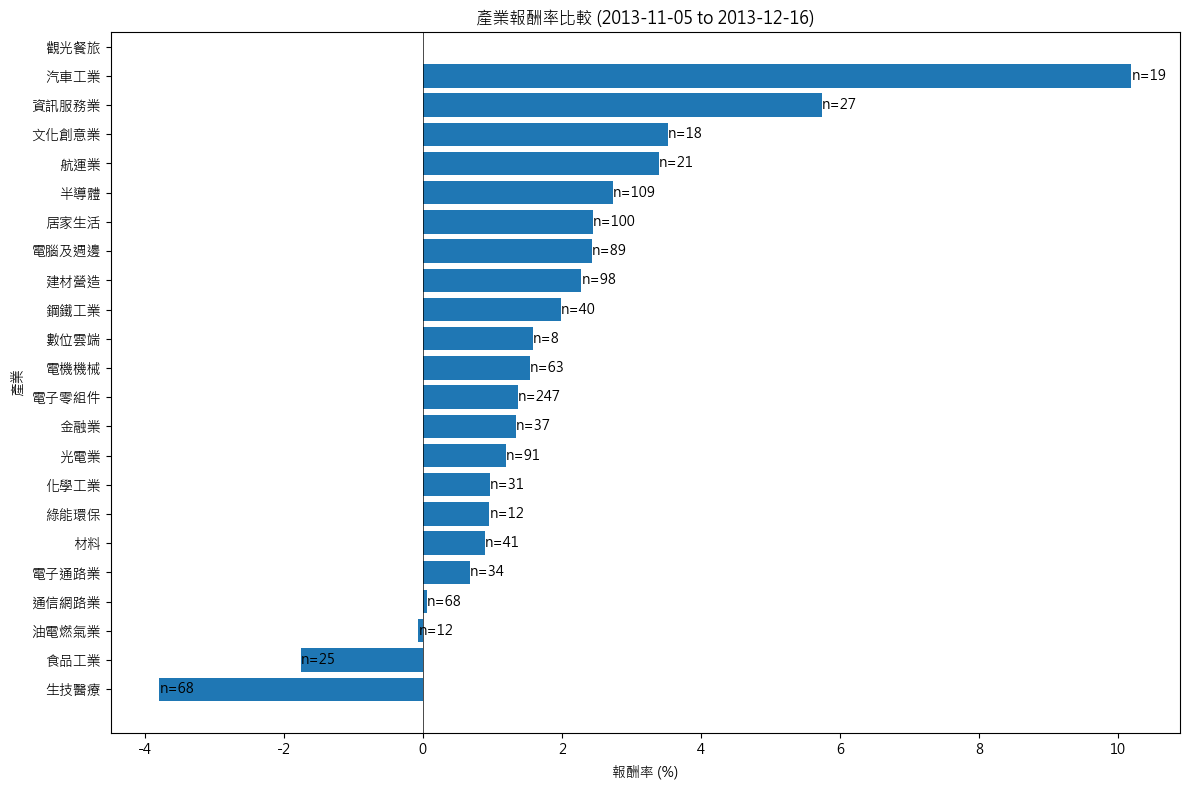

In [31]:

returns_df = plot_industry_returns(close_industry, '2013-11-05', '2013-12-16')
plt.show()